# Datenanalyse in der Medizin - ein einführendes Beispiel

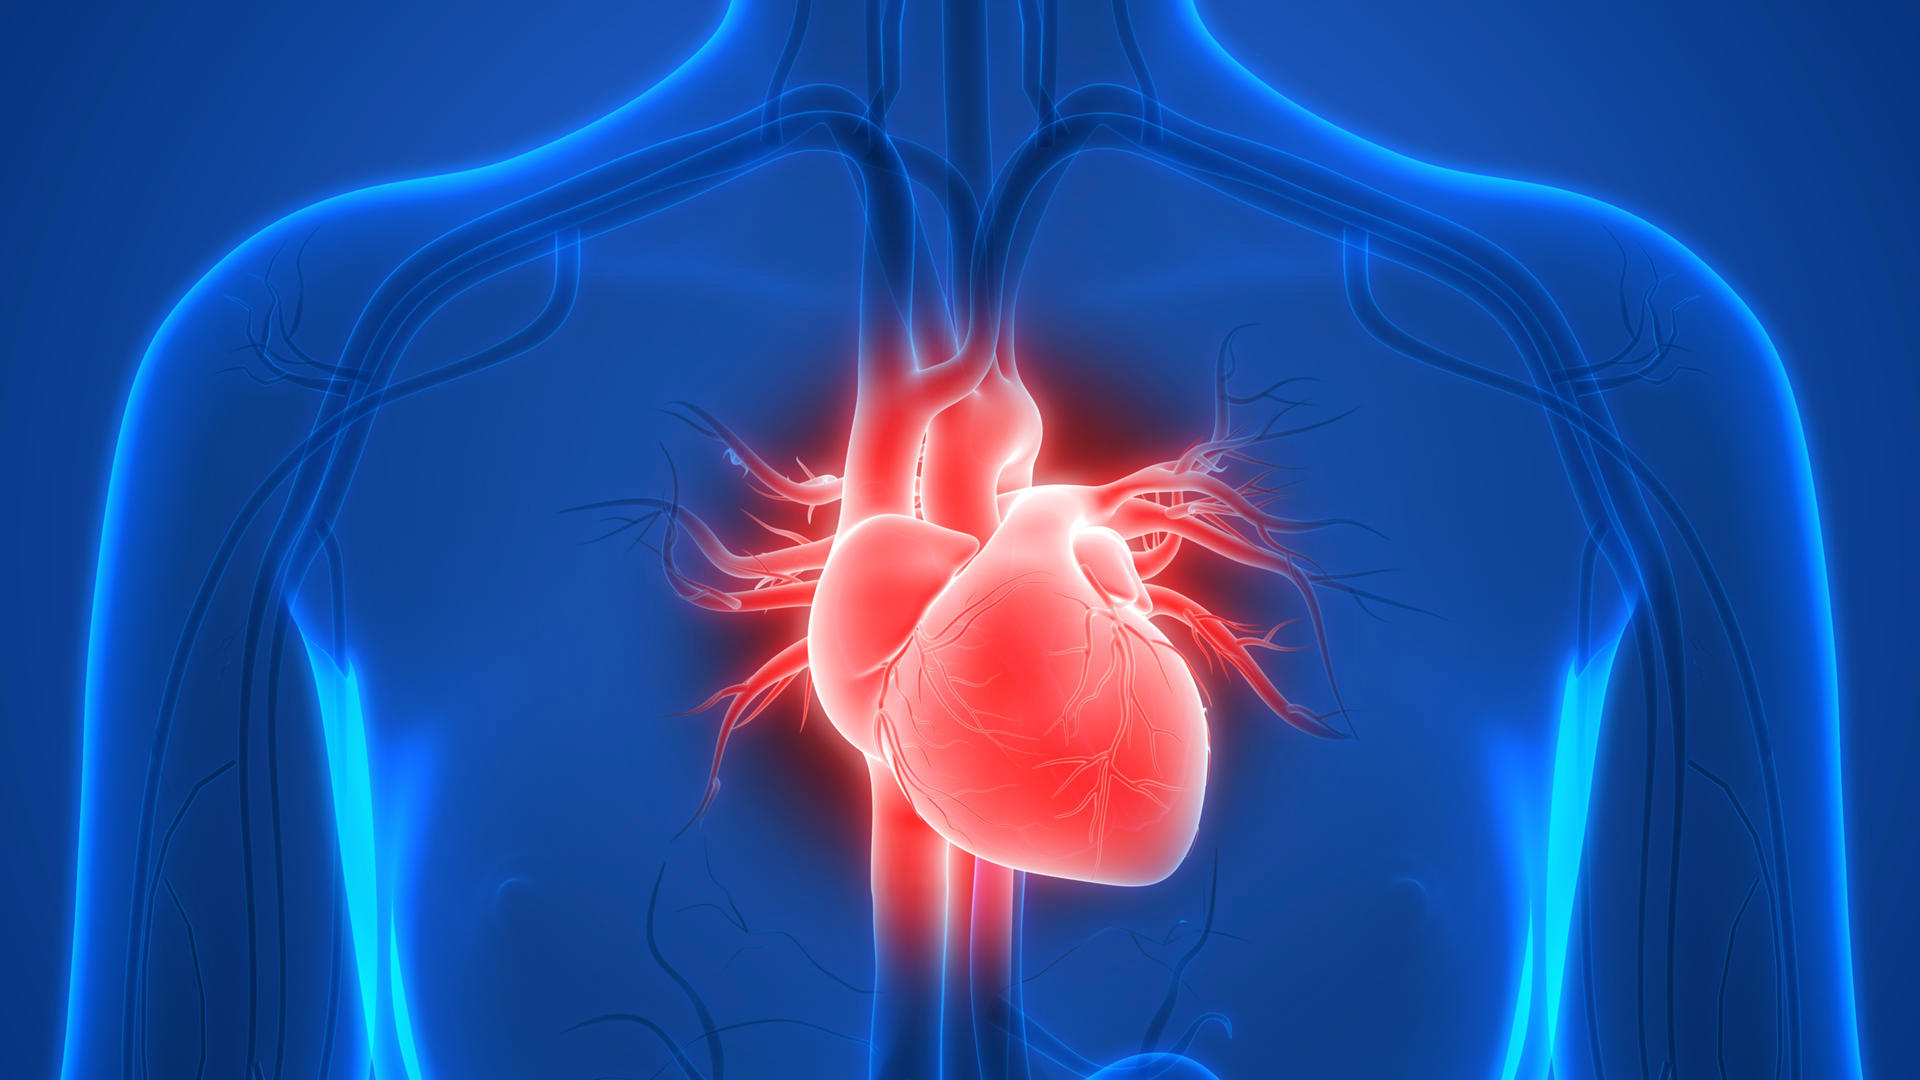

In [1]:
from IPython.display import Image
Image('Titelbild.jpg') # https://www.t-online.de/gesundheit/krankheiten-symptome/id_65321640/koronare-herzkrankheit-ursachen-diagnose-und-behandlung.html

### Notebook zu Kapitel 2 des Vorlesungsskripts "Analyse multivariater Daten"

In dieser Beispielanalyse untersuchen wir einen medizinischen Datensatz mit 
Informationen über Risikofaktoren für Herzkrankheiten. Enthalten sind insgesamt 
14 Merkmale, die im Folgenden kurz beschrieben sind:
    
    1. age: Alter des Patienten (in Jahren)
    2. sex: Geschlecht des Patienten (0 = weiblich, 1 = männlich)
    3. cp: Brustschmerz (0 = typisch, 1 = atypisch, 2 = nicht-anginös, 3 = asymptotisch)
    4. trestbps: Ruheblutdruck (in mmHg, gemessen bei der Krankenhauseinlieferung)
    5. chol: Cholesterinspiegel (in mg/dl)
    6. fbs: Blutzuckerspiegel > 120 mg/dl (0 = false, 1 = true)
    7. restecg: Ergebnis des Ruhe-EKGs (0 = normal, 1 = ST-T Abnormalität, 2 = Anzeichen von linksventrikulärer Hypertrophie)
    8. thalach: maximale Herzfrequenz (in bpm)
    9. exang: bewegungsinduzierte Angina (0 = false, 1 = true)
    10. oldpeak: bewegungsinduzierte ST-Streckensenkung relativ zu Ruhe
    11. slope: Verlauf des ST-Segments bei Spitzenlast (1 = steigend, 2 = flach, 3 = fallend)
    12. ca: Anzahl der durch Fluoroskopie eingefärbten Hauptgefäße (0 - 3)
    13. thal: Thalassämie (0 = normal, 1 = fester Defekt, 2 = reversibler Defekt) 
    14. target: Vorliegen von Herzkrankheiten (0 = false, 1 = true)
    
Der ursprüngliche Datensatz umfasst sogar 76 Merkmale. Alle bisherigen 
Veröffentlichungen referenzieren allerdings den hier aufgelisteten Merkmalsraum, 
weshalb wir uns ohne weitere Angabe von Gründen ebenfalls darauf beschränken.

Im Rahmen der Analyse werden wir ein paar grundlegende Techniken der 
Dateninspektion, -vorbehandlung, -strukturanalyse, -reduktion, -modellierung 
und -modellvalidierung gemäß der Inhalte des Vorlesungsskripts "Analyse multivariater 
Daten" anwenden (sofern dies methodisch angemessen erscheint).

Ziel ist neben der Datenexploration auch die Konstruktion eines geeigneten Modells zur Vorhersage des Vorliegens von Herzkrankheiten (target). Als Kursteilnehmer sollen Sie anhand dieses Beispiels einen ersten Eindruck erhalten, auf welche Weise reale Daten durch die Vereinigung von Statistik und Data Science untersucht werden können. Sie können es auch für das "Tracking" Ihres Lernfortschritts im Semester oder als Starthilfe für eigene Datenanalysen verwenden.

### Importieren der Pakete

In [2]:
import pandas as pd
import numpy as np
    
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
import time

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#### Voreinstellungen

In [3]:
# Plotting
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style='darkgrid')

# Warnungen unterdrücken
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Laden des Datensatzes

In [4]:
# Einlesen der Datei als Dataframe
df = pd.read_csv('heart.csv')
df.head(5)
#print(df.head(5).to_latex(index=False))  

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Analyse der Metadaten

#### Dimensionen des Datensatzes

In [5]:
# Anzahl der Zeilen
nrows = df.shape[0]

# Anzahl der Spalten
ncols = df.shape[1]

print('Dimensionen des Datensatzes: ' + str(nrows) + ' Zeilen (Beobachtungen) und ' + str(ncols) + ' Spalten (Variablen)')

Dimensionen des Datensatzes: 303 Zeilen (Beobachtungen) und 14 Spalten (Variablen)


#### Informationen über die Merkmale

##### Merkmalsnamen

In [6]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

##### Anzahl fehlender Werte je Merkmal

In [7]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

##### Datentypen

In [8]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

##### Anzahl unterschiedlicher Werte je Merkmal

In [9]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

##### Einteilung in metrische und kategoriale Variablen

In [10]:
# metrisch
mvars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# kategorial
cvars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

# kategorial ohne Zielvariable
ctvars = cvars.copy()
ctvars.remove('target')

### Dateninspektion und -vorbehandlung

#### Univariate Plots

##### Metrische Variablen

<Figure size 864x648 with 0 Axes>

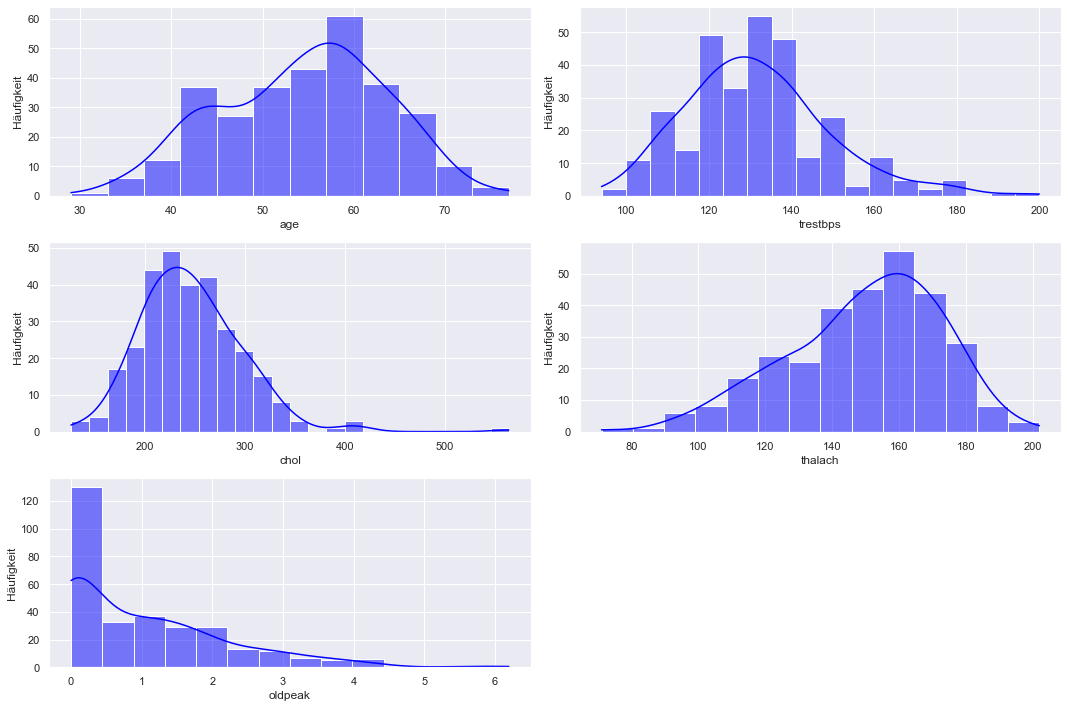

In [11]:
pos = [[0,0], [0,1], [1,0], [1,1], [2,0]]

plt.figure()
fig, axes = plt.subplots(3, 2)
fig.delaxes(axes[2, 1])
fig.set_figheight(10)
fig.set_figwidth(15)

i = 0
for var in mvars:
    ax = sns.histplot(df[var], kde=True, color='blue', ax=axes[pos[i][0], pos[i][1]])
    ax.set(ylabel='Häufigkeit')
    i += 1
    
plt.tight_layout()
plt.savefig('../AMD_Skript_WS2122/Grafiken/Kap2/univMetr.pdf')
plt.show()

##### Kategoriale Variablen

<Figure size 864x648 with 0 Axes>

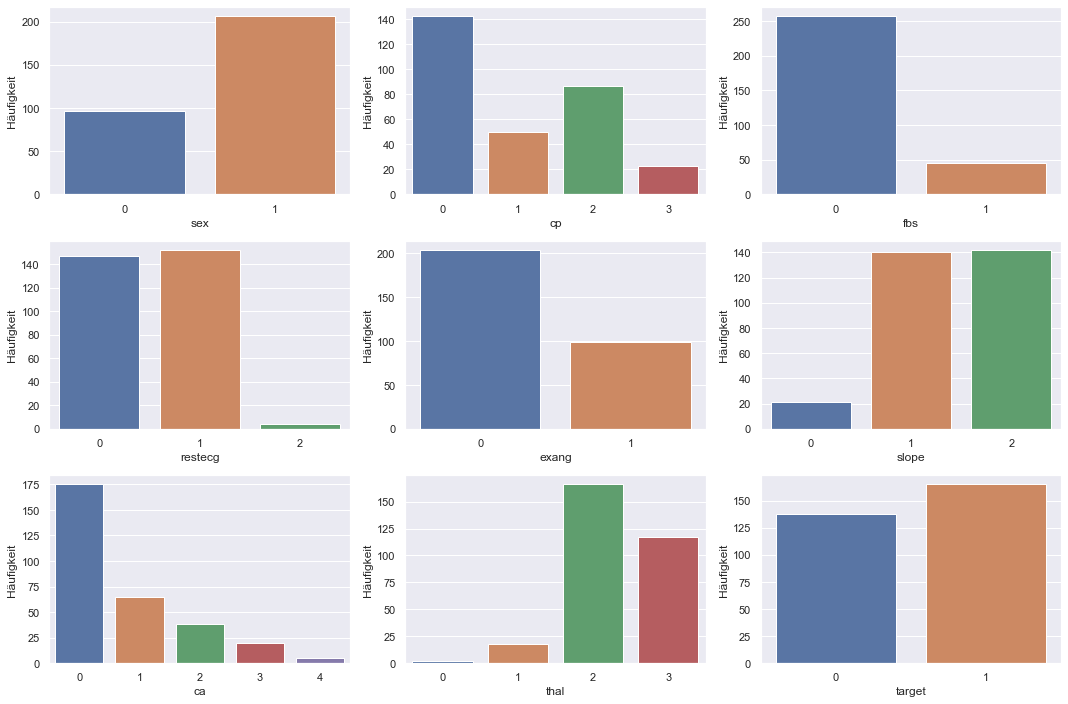

In [12]:
pos = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2], [3,0], [3,1], [3,2]]

plt.figure()
fig, axes = plt.subplots(3, 3)
fig.set_figheight(10)
fig.set_figwidth(15)

i = 0
for var in cvars:
    ax = sns.countplot(x=var, data=df, ax=axes[pos[i][0], pos[i][1]]) 
    ax.set(ylabel='Häufigkeit')
    i += 1

plt.tight_layout()
plt.savefig('../AMD_Skript_WS2122/Grafiken/Kap2/univCat.pdf')
plt.show()

##### Metrische Variablen vs. Zielvariable

<Figure size 1008x216 with 0 Axes>

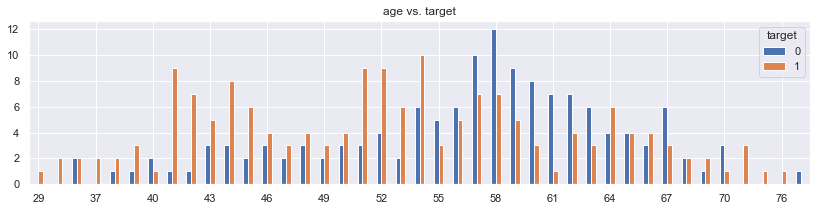

<Figure size 1008x216 with 0 Axes>

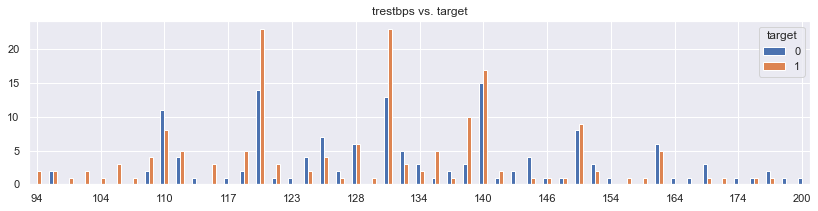

<Figure size 1008x216 with 0 Axes>

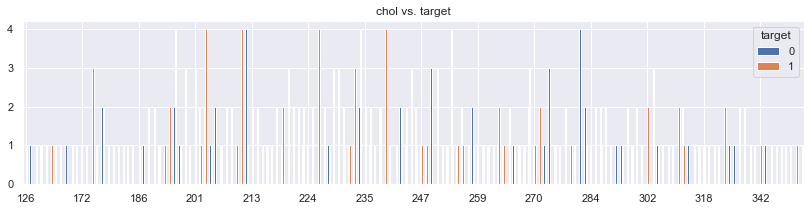

<Figure size 1008x216 with 0 Axes>

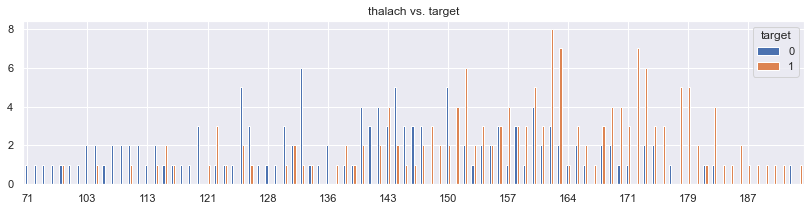

<Figure size 1008x216 with 0 Axes>

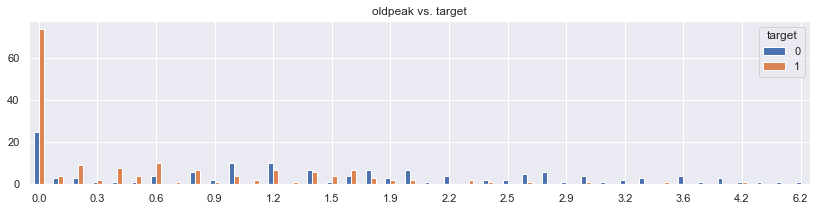

In [13]:
plt.rcParams['figure.figsize'] = [14, 3]
for var in mvars:  
    plt.figure()
    pd.crosstab(df[var], df['target']).plot(kind='bar')
    plt.locator_params(axis='x', nbins=15)
    plt.xticks(rotation=0)
    plt.xlabel('')
    plt.title(var + ' vs. target')
    plt.savefig('../AMD_Skript_WS2122/Grafiken/Kap2/' + var + '.pdf')
    plt.show()
plt.rcParams['figure.figsize'] = [12, 9]

##### Kategoriale Variablen vs. Zielvariable

<Figure size 864x648 with 0 Axes>

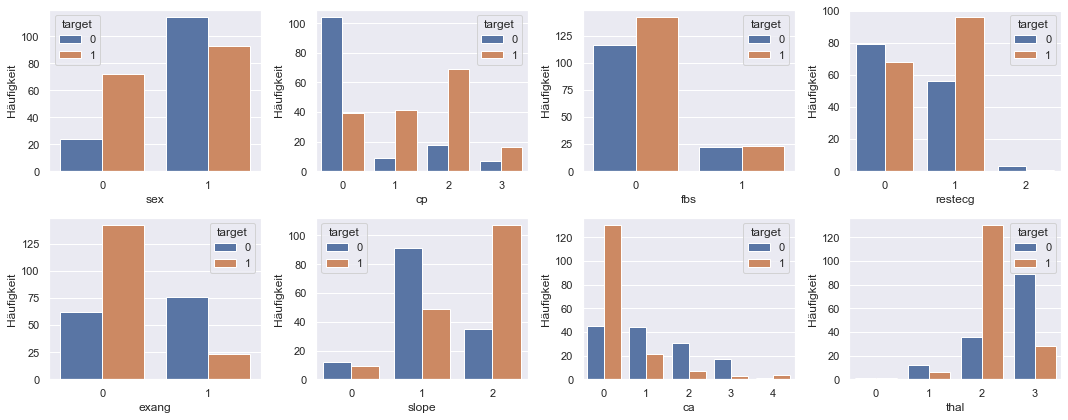

In [14]:
pos = [[0,0], [0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3]]

plt.figure()
fig, axes = plt.subplots(2, 4)
fig.set_figheight(6)
fig.set_figwidth(15)

i = 0
for var in ctvars:
    ax = sns.countplot(x=var, data=df, hue='target', ax=axes[pos[i][0], pos[i][1]]) 
    ax.set(ylabel='Häufigkeit')
    i += 1

plt.tight_layout()
plt.savefig('../AMD_Skript_WS2122/Grafiken/Kap2/catTarg.pdf')
plt.show()

#### Bivariate Plots

##### Pairplot für metrische Variablen vs. Zielvariable

<Figure size 1296x216 with 0 Axes>

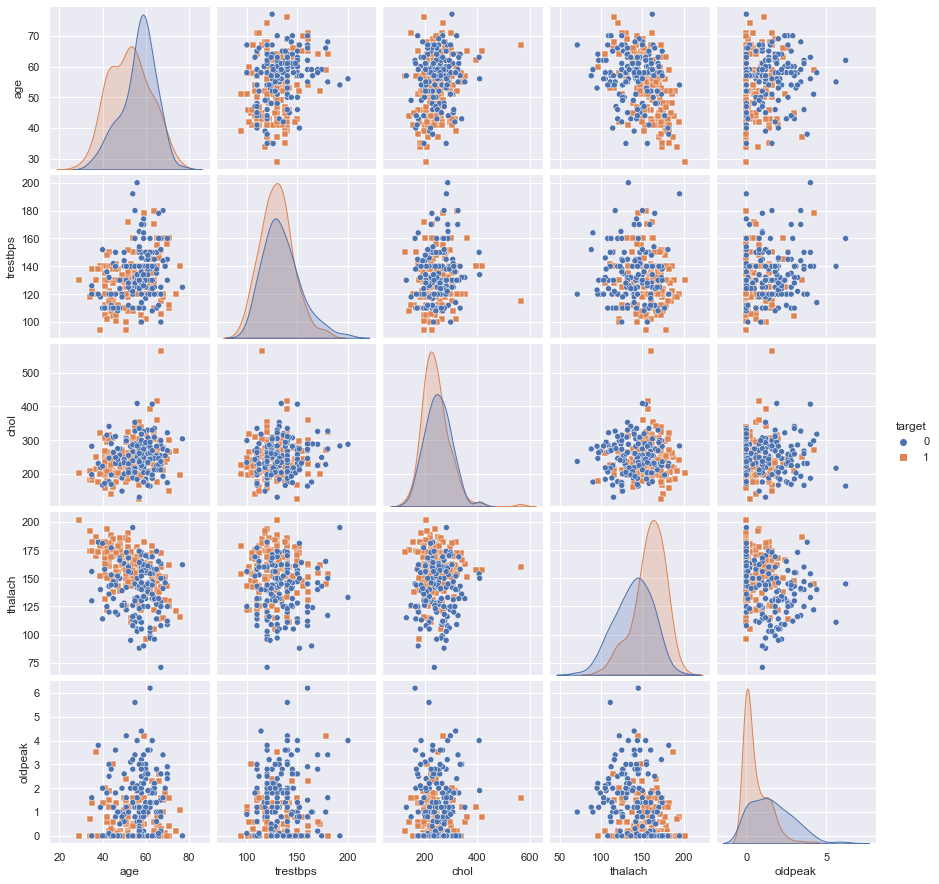

In [15]:
plt.rcParams['figure.figsize'] = [18, 3]
plt.figure()
sns.pairplot(pd.concat((df[mvars], df['target']), axis=1), markers=['o','s'], hue='target', corner=False)
plt.savefig('../AMD_Skript_WS2122/Grafiken/Kap2/bivMetr.pdf')
plt.show()
plt.rcParams['figure.figsize'] = [12, 9]

#### Statistische Beschreibung des Datensatzes

In [16]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


#### Stratifiziertes Resampling mit K-Fold

In [17]:
def kfold(df):

    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    for val, (train_idx, val_idx) in enumerate(skf.split(df[mvars+ctvars], df['target'])):
        df.loc[val_idx, 'fold'] = int(val)

    df['fold'] = df['fold'].astype(int)

    return df

In [18]:
df = kfold(df)
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,fold
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,4
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,4
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,4
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,3


#### Einteilung in Trainings- und Testdaten

In [19]:
train = df[df['fold']!=0].reset_index(drop=True)
test = df[df['fold']==0].reset_index(drop=True)

In [20]:
train.shape, test.shape

((252, 15), (51, 15))

#### Anpassung der Datentypen

In [21]:
def changeDtypes(df):
    
    df[ctvars] = df[ctvars].astype(object)
    
    return df

In [22]:
train = changeDtypes(train)
test = changeDtypes(test)

#### Clean-Up für "ca" und "thal"

In [23]:
def makeConsistent(df):
    
    df['ca'] = df['ca'].replace([4], 3)
    df['thal'] = df['thal'].replace([0], 1)
    
    return df

In [24]:
train = makeConsistent(train)
test = makeConsistent(test)

#### Ausreißeranalyse

In [25]:
def removeOutliers(df):   
    
    lof = LocalOutlierFactor()
    outl = lof.fit_predict(df[mvars])
    mask = outl!=-1
    df = df.iloc[mask, :].reset_index(drop=True)
    
    return df, mask

In [26]:
train, mask = removeOutliers(train)
print(train.shape)
train.head(5)

(244, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,fold
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,4
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,4
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,4
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,3


In [27]:
print('Anzahl erkannter Ausreißer: ' + str(df[df['fold']!=0].iloc[~mask, :].shape[0]))
df[df['fold']!=0].iloc[~mask, :]

Anzahl erkannter Ausreißer: 8


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,fold
28,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1,4
53,44,0,2,108,141,0,1,175,0,0.6,1,0,2,1,3
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1,3
96,62,0,0,140,394,0,0,157,0,1.2,1,0,2,1,2
220,63,0,0,150,407,0,0,154,0,4.0,1,3,3,0,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0,2
272,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0,2
297,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0,3


#### Datentransformation

##### Kodierung der kategorialen Variablen

In [28]:
def encodeCategoricals(df, method):
    
    for col in ctvars:
                            
        if method=='train':
            ohe = OneHotEncoder(handle_unknown='ignore')
            sub = np.array(df[col]).reshape(-1,1)
            transf = pd.DataFrame.sparse.from_spmatrix(ohe.fit_transform(sub)).reset_index(drop=True)
            transf = transf.sparse.to_dense()
            transf.columns = list(ohe.get_feature_names([col]))
            transf = transf.astype(object)
            df = pd.concat((df, transf), axis=1)
            
            dump(ohe, col + '_ohe.joblib')
            
        if method=='test':
            ohe = load(col + '_ohe.joblib')
            sub = np.array(df[col]).reshape(-1,1)
            transf = pd.DataFrame.sparse.from_spmatrix(ohe.transform(sub)).reset_index(drop=True)
            transf = transf.sparse.to_dense()
            transf.columns = list(ohe.get_feature_names([col]))
            transf = transf.astype(object)
            df = pd.concat((df, transf), axis=1)

    df = df.drop(ctvars, axis=1)
    
    return df

In [29]:
train = encodeCategoricals(train, method='train')
test = encodeCategoricals(test, method='test')
train.head(5)

,age,trestbps,chol,thalach,oldpeak,target,fold,sex_0,sex_1,cp_0,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,4,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,1,4,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,1,4,1,0,0,...,0,0,1,1,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,57,120,354,163,0.6,1,3,1,0,1,...,0,0,1,1,0,0,0,0,1,0


In [30]:
train.shape, test.shape

((244, 30), (51, 30))

##### Standardisierung der metrischen Variablen

In [31]:
def standardize(df, method):
    
    if method=='train':
        scaler = StandardScaler()
        df[mvars] = pd.DataFrame(scaler.fit_transform(df[mvars]))

        dump(scaler, 'standardScaler.joblib')
        
    if method=='test':
        scaler = load('standardScaler.joblib')
        df[mvars] = pd.DataFrame(scaler.transform(df[mvars]))
        
    return df

In [32]:
train = standardize(train, method='train')
test = standardize(test, method='test')
train.head(5)

,age,trestbps,chol,thalach,oldpeak,target,fold,sex_0,sex_1,cp_0,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
0,0.998853,0.819616,-0.207719,0.025980,1.085759,1,4,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,-1.822484,-0.045377,0.169357,1.689423,2.103397,1,4,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,-1.388432,-0.045377,-0.850967,1.015054,0.322530,1,4,1,0,0,...,0,0,1,1,0,0,0,0,1,0
3,0.239262,-0.622038,-0.141176,1.284801,-0.186289,1,1,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,0.347775,-0.622038,2.476176,0.610433,-0.355895,1,3,1,0,1,...,0,0,1,1,0,0,0,0,1,0


### Datenstrukturanalyse und -reduktion

#### Korrelationsanalyse

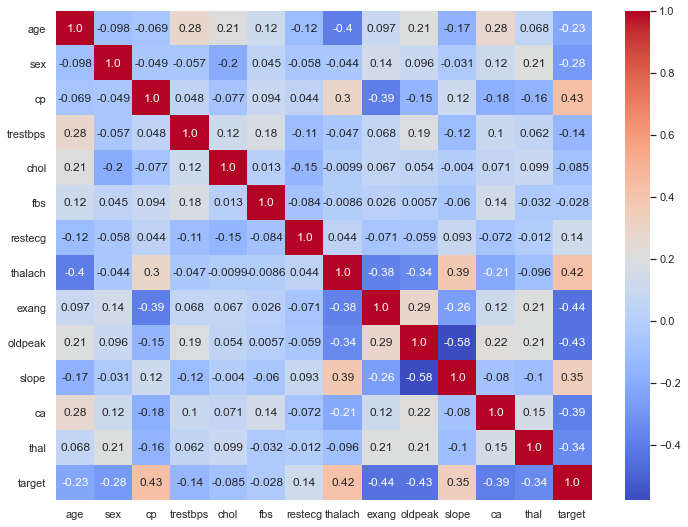

In [33]:
corr_df = df.iloc[:,:-1].corr()
corr_df = corr_df.astype(float)
plt.figure()
sns.heatmap(corr_df, annot=True, fmt='.2' ,cmap='coolwarm')
plt.savefig('../AMD_Skript_WS2122/Grafiken/Kap2/corrMat.pdf')
plt.show()

#### Clusteranalyse mit K-Means

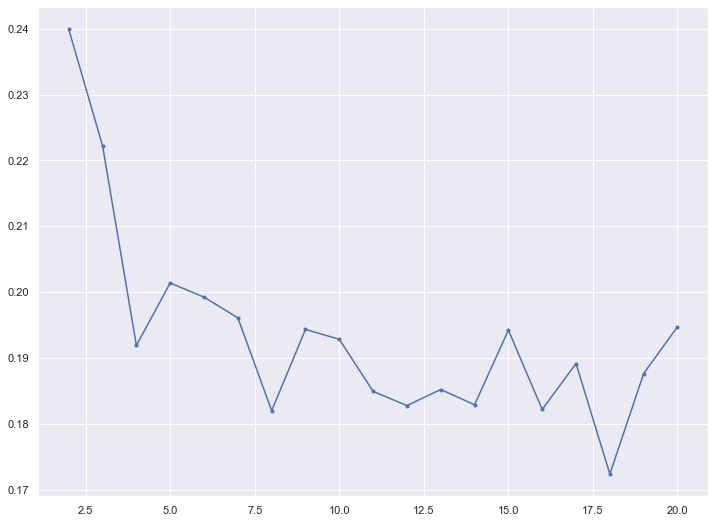

In [34]:
silhouette_scores_km = []

for n_clusters in range(2, 21):
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit_predict(train[mvars])
    silhouette_scores_km.append([n_clusters, silhouette_score(train[mvars], clusters)])

x = [el[0] for el in silhouette_scores_km]
y = [el[1] for el in silhouette_scores_km]

plt.plot(x, y, marker='.')

In [35]:
# Fitte Cluster mit selektierter Anzahl von Clustern
def cluster(df, n_clusters, method):
    
    if method=='train':
        
        km = KMeans(n_clusters=n_clusters, random_state=42)
        clusters_km = km.fit_predict(df[mvars])
        df['cluster'] = clusters_km
        
        dump(km, 'kMeans.joblib')
        
        ohe = OneHotEncoder(handle_unknown='ignore')
        sub = np.array(df['cluster']).reshape(-1,1)
        transf = pd.DataFrame.sparse.from_spmatrix(ohe.fit_transform(sub)).reset_index(drop=True)
        transf = transf.sparse.to_dense()
        transf.columns = list(ohe.get_feature_names(['cluster']))
        transf = transf.astype(object)
        df = pd.concat((df, transf), axis=1)
        
        dump(ohe, 'cluster_ohe.joblib')
        
    if method=='test':
        
        km = load('kMeans.joblib')
        clusters_km = km.predict(df[mvars])
        df['cluster'] = clusters_km
        
        ohe = load('cluster_ohe.joblib')
        sub = np.array(df['cluster']).reshape(-1,1)
        transf = pd.DataFrame.sparse.from_spmatrix(ohe.transform(sub)).reset_index(drop=True)
        transf = transf.sparse.to_dense()
        transf.columns = list(ohe.get_feature_names(['cluster']))
        transf = transf.astype(object)
        df = pd.concat((df, transf), axis=1)
    
    df.drop('cluster', axis=1, inplace=True)

    return df

In [36]:
train = cluster(train, 9, method='train')
test = cluster(test, 9, method='test')
train.head(5)

,age,trestbps,chol,thalach,oldpeak,target,fold,sex_0,sex_1,cp_0,...,thal_3,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.998853,0.819616,-0.207719,0.025980,1.085759,1,4,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,-1.822484,-0.045377,0.169357,1.689423,2.103397,1,4,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,-1.388432,-0.045377,-0.850967,1.015054,0.322530,1,4,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.239262,-0.622038,-0.141176,1.284801,-0.186289,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.347775,-0.622038,2.476176,0.610433,-0.355895,1,3,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [37]:
train[train['cluster_4']==1]

,age,trestbps,chol,thalach,oldpeak,target,fold,sex_0,sex_1,cp_0,...,thal_3,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
152,0.673314,0.819616,0.879147,-0.333684,1.509775,0,4,0,1,1,...,1,0,0,0,0,1,0,0,0,0
154,0.564801,2.261270,1.855109,-0.423599,2.018594,0,4,0,1,1,...,1,0,0,0,0,1,0,0,0,0
171,-1.171406,0.069956,2.187823,-0.603431,1.679381,0,1,1,0,1,...,1,0,0,0,0,1,0,0,0,0
177,0.239262,3.991255,1.012233,-0.738305,2.527413,0,2,1,0,1,...,1,0,0,0,0,1,0,0,0,0
198,-0.303303,0.531285,1.234043,-1.232842,2.697020,0,2,0,1,1,...,1,0,0,0,0,1,0,0,0,0
212,0.130749,2.837932,1.877290,-1.457631,2.018594,0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
224,-1.279919,0.300620,1.611119,-1.097968,0.661743,0,5,0,1,1,...,0,0,0,0,0,1,0,0,0,0
228,-0.845868,0.531285,1.522395,-1.322758,0.661743,0,5,0,1,1,...,1,0,0,0,0,1,0,0,0,0
233,0.456288,-0.968035,1.677661,-0.423599,2.866626,0,4,0,1,1,...,0,0,0,0,0,1,0,0,0,0


#### Hauptkomponentenanalyse

In [38]:
train_ext = train.loc[:,['target', 'fold']]
test_ext = test.loc[:,['target', 'fold']]

In [39]:
pca = PCA(random_state=42)
pcs = pca.fit_transform(train.drop(['target', 'fold'], axis=1))

PCA auf den metrischen Variablen:
Varianzanteile: [2.33674302e-01 1.32110211e-01 1.01105119e-01 8.48374830e-02
 5.92426396e-02 5.86532075e-02 4.95200400e-02 3.83949259e-02
 3.06388700e-02 2.74750024e-02 2.39826668e-02 2.17178925e-02
 2.04615797e-02 1.72470856e-02 1.43312060e-02 1.26908845e-02
 1.12406924e-02 1.01845775e-02 9.47561807e-03 8.80858589e-03
 7.38107929e-03 6.94249224e-03 6.11998940e-03 4.04992457e-03
 3.81746494e-03 2.60562463e-03 1.76595876e-03 1.52487632e-03
 4.60841304e-32 3.10420126e-33 1.15547100e-33 1.15547100e-33
 1.15547100e-33 1.15547100e-33 1.15547100e-33 1.15547100e-33
 4.30098796e-34]


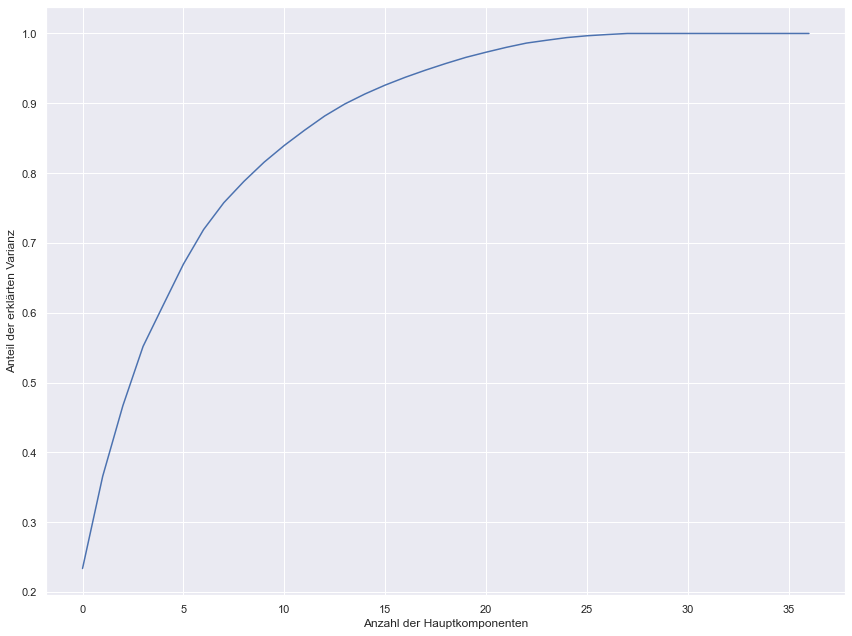

In [40]:
print('PCA auf den metrischen Variablen:')
print('Varianzanteile: ' + str(pca.explained_variance_ratio_))
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Anzahl der Hauptkomponenten')
plt.ylabel('Anteil der erklärten Varianz')
plt.tight_layout()
plt.show()

In [41]:
pcs = pd.DataFrame(pcs)
pcs.columns = ['Z' + str(i) for i in range(0, train.shape[1]-2)]
train = pcs.iloc[:,:18]

In [42]:
pcs_test = pd.DataFrame(pca.transform(test.drop(['target', 'fold'], axis=1)))
pcs_test.columns = ['Z' + str(i) for i in range(0, test.shape[1]-2)]
test = pcs_test.iloc[:,:18]

#### Hinzufügen von target und fold

In [43]:
train = pd.concat((train, train_ext), axis=1)
test = pd.concat((test, test_ext), axis=1)

zvars = [col for col in train if col.startswith('Z')]
fold = 'fold'
targ = 'target'

In [44]:
train.head(5)

,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,target,fold
0,1.268039,0.357827,1.372761,-0.130208,1.021980,0.623044,0.429672,-0.567170,-0.595116,-0.635769,0.643066,0.848624,-0.190399,0.177669,0.434425,0.588343,0.644103,-0.054355,1,4
1,-1.200077,-0.602253,1.628853,2.242423,0.420410,1.588772,-0.926932,-0.186653,-0.213362,0.348843,-0.297255,-0.182984,-0.613510,-0.067433,0.030017,0.079676,0.322420,0.344619,1,4
2,-1.752502,-0.396117,1.011723,0.508136,-0.395376,0.960693,0.816234,0.509792,-0.352688,-0.031238,-0.151361,0.246144,0.771350,0.766232,-0.445775,-0.027070,0.067119,0.123945,1,4
3,-1.446717,0.101149,-0.019110,-0.363666,1.015537,0.381104,-0.671162,0.385440,-0.138782,-0.730720,-0.397562,0.429918,-0.437813,0.379198,-0.064649,-0.579831,0.118478,0.139409,1,1
4,-0.429334,1.935516,-1.793624,1.044251,-0.231602,0.191935,-0.681161,1.439002,-0.172565,-0.233316,0.148793,-0.312328,-0.510543,-0.149871,0.238934,0.515830,0.019227,0.059549,1,3


### (Überwachte) Datenanalysemodelle und -modellvalidierung

In [45]:
# Setze Hyperparameter
thresh = 0.5

In [46]:
# Definiere Testvariablen
X_test, y_test = test[zvars], test[targ]

#### Algorithmus 1: K-Nearest Neighbours

##### Trainingsfunktion

In [47]:
def trainKNN(oof):
    
    knn_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]

        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'n_neighbors': [x for x in range(1, 60)], 
                      'weights': ['uniform', 'distance'],
                      'p': [x for x in range(1,4)]}

        print('  Starte Grid-Search')
        grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimale Parameter: ' + str(grid.best_params_))

        # Model fitten
        print('  Fitte Model ' + str(f))
        knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], 
                                   weights=grid.best_params_['weights'], 
                                   algorithm='auto', 
                                   p=grid.best_params_['p'])

        knn.fit(X_train, y_train)
        knn_mods.append(knn)
        
        # OOF-Vorhersage und Speicherung
        pred = knn.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return knn_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [48]:
knn_oof = np.zeros(train[targ].shape)

start = time.time()
knn_mods = trainKNN(knn_oof)
end = time.time()
knn_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimale Parameter: {'n_neighbors': 59, 'p': 2, 'weights': 'distance'}
  Fitte Model 1
  OOF score: 0.9285714285714286

Fold 2
  Starte Grid-Search
  Optimale Parameter: {'n_neighbors': 44, 'p': 2, 'weights': 'distance'}
  Fitte Model 2
  OOF score: 0.8747795414462081

Fold 3
  Starte Grid-Search
  Optimale Parameter: {'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
  Fitte Model 3
  OOF score: 0.8095238095238095

Fold 4
  Starte Grid-Search
  Optimale Parameter: {'n_neighbors': 48, 'p': 2, 'weights': 'uniform'}
  Fitte Model 4
  OOF score: 0.9147157190635451

Fold 5
  Starte Grid-Search
  Optimale Parameter: {'n_neighbors': 17, 'p': 3, 'weights': 'distance'}
  Fitte Model 5
  OOF score: 0.8921095008051529



##### Binarisierung der OOF-Vorhersagen

In [49]:
knn_oof_bp = pd.DataFrame(knn_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [50]:
start = time.time()

knn_test_pp = np.zeros(y_test.shape)
for mod in knn_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    knn_test_pp += mod_pred/len(knn_mods)
knn_test_bp = pd.DataFrame(knn_test_pp) > thresh

end = time.time()
knn_pred_rt = end-start

#### Algorithmus 2: Lineare Diskriminanzanalyse

##### Trainingsfunktion

In [51]:
def trainLDA(oof):
    
    lda_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]
        
        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'solver': ['svd', 'lsqr', 'eigen'], 
                      'shrinkage': [None, 'auto']}

        print('  Starte Grid-Search')
        grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimale Parameter: ' + str(grid.best_params_))

        # Model fitten
        print('  Fitte Model ' + str(f))
        lda = LinearDiscriminantAnalysis(solver=grid.best_params_['solver'], 
                                         shrinkage=grid.best_params_['shrinkage'])

        lda.fit(X_train, y_train)
        lda_mods.append(lda)
        
        # OOF-Vorhersage und Speicherung
        pred = lda.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return lda_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [52]:
lda_oof = np.zeros(train[targ].shape)

start = time.time()
lda_mods = trainLDA(lda_oof)
end = time.time()
lda_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimale Parameter: {'shrinkage': None, 'solver': 'svd'}
  Fitte Model 1
  OOF score: 0.8680124223602484

Fold 2
  Starte Grid-Search
  Optimale Parameter: {'shrinkage': None, 'solver': 'svd'}
  Fitte Model 2
  OOF score: 0.9029982363315696

Fold 3
  Starte Grid-Search
  Optimale Parameter: {'shrinkage': None, 'solver': 'svd'}
  Fitte Model 3
  OOF score: 0.8152380952380953

Fold 4
  Starte Grid-Search
  Optimale Parameter: {'shrinkage': 'auto', 'solver': 'lsqr'}
  Fitte Model 4
  OOF score: 0.9297658862876255

Fold 5
  Starte Grid-Search
  Optimale Parameter: {'shrinkage': None, 'solver': 'svd'}
  Fitte Model 5
  OOF score: 0.9114331723027376



##### Binarisierung der OOF-Vorhersagen

In [53]:
lda_oof_bp = pd.DataFrame(lda_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [54]:
start = time.time()

lda_test_pp = np.zeros(y_test.shape)
for mod in lda_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    lda_test_pp += mod_pred/len(lda_mods)
lda_test_bp = pd.DataFrame(lda_test_pp) > thresh

end = time.time()
lda_pred_rt = end-start

#### Algorithmus 3: Quadratische Diskriminanzanalyse

##### Trainingsfunktion

In [55]:
def trainQDA(oof):
    
    qda_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]
        
        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'reg_param': [x/100 for x in range(0, 201)]}

        print('  Starte Grid-Search')
        grid = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimaler Parameter: ' + str(grid.best_params_))

        # Model fitten
        print('  Fitte Model ' + str(f))
        qda = QuadraticDiscriminantAnalysis(reg_param=grid.best_params_['reg_param'])

        qda.fit(X_train, y_train)
        qda_mods.append(qda)
        
        # OOF-Vorhersage und Speicherung
        pred = qda.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return qda_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [56]:
qda_oof = np.zeros(train[targ].shape)

start = time.time()
qda_mods = trainQDA(qda_oof)
end = time.time()
qda_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimaler Parameter: {'reg_param': 0.32}
  Fitte Model 1
  OOF score: 0.9130434782608695

Fold 2
  Starte Grid-Search
  Optimaler Parameter: {'reg_param': 0.31}
  Fitte Model 2
  OOF score: 0.91005291005291

Fold 3
  Starte Grid-Search
  Optimaler Parameter: {'reg_param': 0.33}
  Fitte Model 3
  OOF score: 0.8190476190476191

Fold 4
  Starte Grid-Search
  Optimaler Parameter: {'reg_param': 0.51}
  Fitte Model 4
  OOF score: 0.9046822742474916

Fold 5
  Starte Grid-Search
  Optimaler Parameter: {'reg_param': 0.4}
  Fitte Model 5
  OOF score: 0.8969404186795491



##### Binarisierung der OOF-Vorhersagen

In [57]:
qda_oof_bp = pd.DataFrame(qda_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [58]:
start = time.time()

qda_test_pp = np.zeros(y_test.shape)
for mod in qda_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    qda_test_pp += mod_pred/len(qda_mods)
qda_test_bp = pd.DataFrame(qda_test_pp) > thresh

end = time.time()
qda_pred_rt = end-start

#### Algorithmus 4: Logistische Regression

##### Trainingsfunktion

In [59]:
def trainLR(oof):
    
    lr_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]

        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'penalty': ['l1', 'l2'],
                      'C': [x/100 for x in range(1,201)],
                      'solver': ['liblinear']}

        print('  Starte Grid-Search')
        grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimale Parameter: ' + str(grid.best_params_))

        # Model fitten
        print('  Fitte Model ' + str(f))
        lr = LogisticRegression(penalty=grid.best_params_['penalty'], 
                                C=grid.best_params_['C'], 
                                solver='liblinear', 
                                random_state=42)
        lr.fit(X_train, y_train)
        lr_mods.append(lr)
        
        # OOF-Vorhersage und Speicherung
        pred = lr.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return lr_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [60]:
lr_oof = np.zeros(train[targ].shape)

start = time.time()
lr_mods = trainLR(lr_oof)
end = time.time()
lr_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimale Parameter: {'C': 0.14, 'penalty': 'l2', 'solver': 'liblinear'}
  Fitte Model 1
  OOF score: 0.8990683229813664

Fold 2
  Starte Grid-Search
  Optimale Parameter: {'C': 0.51, 'penalty': 'l1', 'solver': 'liblinear'}
  Fitte Model 2
  OOF score: 0.9012345679012346

Fold 3
  Starte Grid-Search
  Optimale Parameter: {'C': 0.88, 'penalty': 'l1', 'solver': 'liblinear'}
  Fitte Model 3
  OOF score: 0.8228571428571428

Fold 4
  Starte Grid-Search
  Optimale Parameter: {'C': 0.82, 'penalty': 'l1', 'solver': 'liblinear'}
  Fitte Model 4
  OOF score: 0.9214046822742474

Fold 5
  Starte Grid-Search
  Optimale Parameter: {'C': 0.25, 'penalty': 'l2', 'solver': 'liblinear'}
  Fitte Model 5
  OOF score: 0.9194847020933977



##### Binarisierung der OOF-Vorhersagen

In [61]:
lr_oof_bp = pd.DataFrame(lr_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [62]:
start = time.time()

lr_test_pp = np.zeros(y_test.shape)
for mod in lr_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    lr_test_pp += mod_pred/len(lr_mods)
lr_test_bp = pd.DataFrame(lr_test_pp) > thresh

end = time.time()
lr_pred_rt = end-start

#### Algorithmus 5: Random Forest

##### Trainingsfunktion

In [63]:
def trainRF(oof):
    
    rf_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]

        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'n_estimators': [x*5 for x in range(1, 21)],
                      'criterion': ['gini', 'entropy'],
                      'max_depth': [x for x in range(1, 16)]}

        print('  Starte Grid-Search')
        grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimale Parameter: ' + str(grid.best_params_))

        # Model fitten
        print('  Fitte Model ' + str(f))
        rf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                    criterion=grid.best_params_['criterion'],
                                    max_depth=grid.best_params_['max_depth'],
                                    n_jobs=-1,
                                    random_state=42)
        rf.fit(X_train, y_train)
        rf_mods.append(rf)
        
        # OOF-Vorhersage und Speicherung
        pred = rf.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return rf_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [64]:
rf_oof = np.zeros(train[targ].shape)

start = time.time()
rf_mods = trainRF(rf_oof)
end = time.time()
rf_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimale Parameter: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 95}
  Fitte Model 1
  OOF score: 0.8866459627329192

Fold 2
  Starte Grid-Search
  Optimale Parameter: {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 95}
  Fitte Model 2
  OOF score: 0.8562610229276896

Fold 3
  Starte Grid-Search
  Optimale Parameter: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 55}
  Fitte Model 3
  OOF score: 0.8571428571428571

Fold 4
  Starte Grid-Search
  Optimale Parameter: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 20}
  Fitte Model 4
  OOF score: 0.8653846153846154

Fold 5
  Starte Grid-Search
  Optimale Parameter: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
  Fitte Model 5
  OOF score: 0.8752012882447665



##### Binarisierung der OOF-Vorhersagen

In [65]:
rf_oof_bp = pd.DataFrame(rf_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [66]:
start = time.time()

rf_test_pp = np.zeros(y_test.shape)
for mod in rf_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    rf_test_pp += mod_pred/len(rf_mods)
rf_test_bp = pd.DataFrame(rf_test_pp) > thresh

end = time.time()
rf_pred_rt = end-start

#### Algorithmus 6: AdaBoost

##### Trainingsfunktion

In [67]:
def trainAB(oof):
    
    ab_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]

        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'base_estimator': [DecisionTreeClassifier(), RandomForestClassifier()],
                      'n_estimators': [x*5 for x in range(1, 41)], 
                      'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
                      'algorithm': ['SAMME.R', 'SAMME']}

        print('  Starte Grid-Search')
        grid = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimale Parameter: ' + str(grid.best_params_))

        # Model fitten
        print('  Fitte Model ' + str(f))
        ab = AdaBoostClassifier(base_estimator=grid.best_params_['base_estimator'], 
                                n_estimators=grid.best_params_['n_estimators'], 
                                learning_rate=grid.best_params_['learning_rate'], 
                                algorithm=grid.best_params_['algorithm'], 
                                random_state=42)
        ab.fit(X_train, y_train)
        ab_mods.append(ab)
        
        # OOF-Vorhersage und Speicherung
        pred = ab.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return ab_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [68]:
ab_oof = np.zeros(train[targ].shape)

start = time.time()
ab_mods = trainAB(ab_oof)
end = time.time()
ab_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimale Parameter: {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(), 'learning_rate': 0.5, 'n_estimators': 25}
  Fitte Model 1
  OOF score: 0.8850931677018634

Fold 2
  Starte Grid-Search
  Optimale Parameter: {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(), 'learning_rate': 0.1, 'n_estimators': 40}
  Fitte Model 2
  OOF score: 0.8624338624338624

Fold 3
  Starte Grid-Search
  Optimale Parameter: {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(), 'learning_rate': 0.5, 'n_estimators': 130}
  Fitte Model 3
  OOF score: 0.8200000000000001

Fold 4
  Starte Grid-Search
  Optimale Parameter: {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(), 'learning_rate': 0.5, 'n_estimators': 200}
  Fitte Model 4
  OOF score: 0.9122073578595318

Fold 5
  Starte Grid-Search
  Optimale Parameter: {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(), 'learning_rate': 0.5, 'n_estimators': 6

##### Binarisierung der OOF-Vorhersagen

In [69]:
ab_oof_bp = pd.DataFrame(ab_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [70]:
start = time.time()

ab_test_pp = np.zeros(y_test.shape)
for mod in ab_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    ab_test_pp += mod_pred/len(ab_mods)
ab_test_bp = pd.DataFrame(ab_test_pp) > thresh

end = time.time()
ab_pred_rt = end-start

#### Algorithmus 7: Support Vector Machine

##### Trainingsfunktion

In [71]:
def trainSVM(oof):
    
    svm_mods = []
    
    for f in np.sort(train[fold].unique()):

        print('Fold ' + str(f))

        # Einteilung in Trainings- und Validierungsdaten
        X_train, y_train = train[zvars][train[fold]!=f], train[targ][train[fold]!=f]
        X_val, y_val = train[zvars][train[fold]==f], train[targ][train[fold]==f]

        # Speichern der Validierungsindizes (für den Eintrag in die OOF-Vorhersagen)
        val_idx = y_val.index

        # Grid-Search für die Modellparameter
        param_grid = {'C': [x/10 for x in range(0, 300)],
                      'kernel': ['rbf', 'poly'],
                      'gamma': ['auto', 'scale']}

        print('  Starte Grid-Search')
        grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        print('  Optimaler Parameter: ' + str(grid.best_params_))
        
        # Model fitten
        print('  Fitte Model ' + str(f))
        svm = SVC(C=grid.best_params_['C'], 
                  kernel=grid.best_params_['kernel'], 
                  gamma=grid.best_params_['gamma'], 
                  probability=True,
                  random_state=42)
        svm.fit(X_train, y_train)
        svm_mods.append(svm)
        
        # OOF-Vorhersage und Speicherung
        pred = svm.predict_proba(X_val)[:,1]
        oof[val_idx] = pred

        # Scoring anzeigen
        score = roc_auc_score(y_val, pred)
        print('  OOF score: ' + str(score))
        print('')
        
    return svm_mods

##### Ausführung und Speichern der OOF-Vorhersagen sowie der Vorhersagemodelle

In [72]:
svm_oof = np.zeros(train[targ].shape)

start = time.time()
svm_mods = trainSVM(svm_oof)
end = time.time()
svm_training_rt = end-start

Fold 1
  Starte Grid-Search
  Optimaler Parameter: {'C': 0.9, 'gamma': 'auto', 'kernel': 'rbf'}
  Fitte Model 1
  OOF score: 0.9068322981366459

Fold 2
  Starte Grid-Search
  Optimaler Parameter: {'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
  Fitte Model 2
  OOF score: 0.8783068783068784

Fold 3
  Starte Grid-Search
  Optimaler Parameter: {'C': 0.6, 'gamma': 'auto', 'kernel': 'rbf'}
  Fitte Model 3
  OOF score: 0.8304761904761905

Fold 4
  Starte Grid-Search
  Optimaler Parameter: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
  Fitte Model 4
  OOF score: 0.9264214046822743

Fold 5
  Starte Grid-Search
  Optimaler Parameter: {'C': 0.9, 'gamma': 'auto', 'kernel': 'rbf'}
  Fitte Model 5
  OOF score: 0.8840579710144928



##### Binarisierung der OOF-Vorhersagen

In [73]:
svm_oof_bp = pd.DataFrame(svm_oof) > thresh

##### Vorhersage auf den Testdaten und Binarisierung

In [74]:
start = time.time()

svm_test_pp = np.zeros(y_test.shape)
for mod in svm_mods:
    mod_pred = mod.predict_proba(X_test)[:,1]
    svm_test_pp += mod_pred/len(svm_mods)
svm_test_bp = pd.DataFrame(svm_test_pp) > thresh

end = time.time()
svm_pred_rt = end-start

### Analyse der Vorhersageergebnisse

#### Erstelle Tabellen für die Dokumentation der Ergebnisse

In [75]:
# Tabelle für OOF-Ergebnisse
oof_res = pd.DataFrame(0, index=['Accuracy ' + r' $\uparrow$',
                                 'Precision ' + r' $\uparrow$',
                                 'Recall ' + r' $\uparrow$',
                                 'F1 ' + r' $\uparrow$',
                                 'AUC ' + r' $\uparrow$'],
                       columns=['KNN', 'LDA', 'QDA', 'LR', 'RF', 'AB', 'SVM'])

# Tabelle für Testergebnisse
test_res = pd.DataFrame(0, index=['Accuracy ' + r' $\uparrow$',
                                  'Precision ' + r' $\uparrow$',
                                  'Recall ' + r' $\uparrow$',
                                  'F1 ' + r' $\uparrow$',
                                  'AUC ' + r' $\uparrow$'],
                        columns=['KNN', 'LDA', 'QDA', 'LR', 'RF', 'AB', 'SVM'])

# Tabelle für Laufzeiten
runtime_res = pd.DataFrame(0, index=['Training ' + r' $\downarrow$',
                                  'Vorhersage ' + r' $\downarrow$'],
                        columns=['KNN', 'LDA', 'QDA', 'LR', 'RF', 'AB', 'SVM'])

#### Funktion zur Berechnung der Metriken

In [76]:
# Funktion zur Erstellung eines Metrik-Reports
def getMetrics(y, prob_pred, bin_pred):

    # Accuracy
    acc = accuracy_score(y, bin_pred)
    
    # Precision
    prec = precision_score(y, bin_pred)
    
    # Recall
    rec = recall_score(y, bin_pred)
    
    # F1
    f1 = f1_score(y, bin_pred)
    
    # AUC
    auc = roc_auc_score(y, prob_pred)
    
    metriken = np.array((acc, prec, rec, f1, auc))
    
    return metriken

#### Berechnung der Metriken und Einsetzen der Werte in die Tabellen

##### OOF

In [77]:
# KNN
oof_res_knn = getMetrics(train[targ], knn_oof, knn_oof_bp)
oof_res['KNN'] = oof_res_knn.round(4)

# LDA
oof_res_lda = getMetrics(train[targ], lda_oof, lda_oof_bp)
oof_res['LDA'] = oof_res_lda.round(4)

# QDA
oof_res_qda = getMetrics(train[targ], qda_oof, qda_oof_bp)
oof_res['QDA'] = oof_res_qda.round(4)

# LR
oof_res_lr = getMetrics(train[targ], lr_oof, lr_oof_bp)
oof_res['LR'] = oof_res_lr.round(4)

# RF
oof_res_rf = getMetrics(train[targ], rf_oof, rf_oof_bp)
oof_res['RF'] = oof_res_rf.round(4)

# AB
oof_res_ab = getMetrics(train[targ], ab_oof, ab_oof_bp)
oof_res['AB'] = oof_res_ab.round(4)

# SVM
oof_res_svm = getMetrics(train[targ], svm_oof, svm_oof_bp)
oof_res['SVM'] = oof_res_svm.round(4)

##### Formatierung der besten Werte je Zeile

In [78]:
subCol = list(range(0, oof_res.shape[1]))

oof_accs = []
oof_precs = []
oof_recs = []
oof_f1s = []
oof_aucs = []
for c in subCol:
    oof_accs.append(float(oof_res.iloc[0,c]))
    oof_precs.append(float(oof_res.iloc[1,c]))
    oof_recs.append(float(oof_res.iloc[2,c]))
    oof_f1s.append(float(oof_res.iloc[3,c]))
    oof_aucs.append(float(oof_res.iloc[4,c]))
    
oof_best_vals = [subCol[int(np.where(np.array(oof_accs)==max(oof_accs))[0])], 
                 subCol[int(np.where(np.array(oof_precs)==max(oof_precs))[0])],
                 subCol[int(np.where(np.array(oof_recs)==max(oof_recs))[0])],
                 subCol[int(np.where(np.array(oof_f1s)==max(oof_f1s))[0])],
                 subCol[int(np.where(np.array(oof_aucs)==max(oof_aucs))[0])]]

for row in range(0,len(oof_res.index)):
    oof_res.iloc[row,:] = oof_res.iloc[row,:].replace({oof_res.iloc[row,oof_best_vals[row]]: r'\textbf{' + str(oof_res.iloc[row,oof_best_vals[row]]) + '}'})

In [79]:
oof_res.reset_index(level=0, inplace=True)
oof_res.rename(columns = {'index':'Metrik'}, inplace = True)

##### Test

In [80]:
# KNN
test_res_knn = getMetrics(test[targ], knn_test_pp, knn_test_bp)
test_res['KNN'] = test_res_knn.round(4)

# LDA
test_res_lda = getMetrics(test[targ], lda_test_pp, lda_test_bp)
test_res['LDA'] = test_res_lda.round(4)

# QDA
test_res_qda = getMetrics(test[targ], qda_test_pp, qda_test_bp)
test_res['QDA'] = test_res_qda.round(4)

# LR
test_res_lr = getMetrics(test[targ], lr_test_pp, lr_test_bp)
test_res['LR'] = test_res_lr.round(4)

# RF
test_res_rf = getMetrics(test[targ], rf_test_pp, rf_test_bp)
test_res['RF'] = test_res_rf.round(4)

# AB
test_res_ab = getMetrics(test[targ], ab_test_pp, ab_test_bp)
test_res['AB'] = test_res_ab.round(4)

# SVM
test_res_svm = getMetrics(test[targ], svm_test_pp, svm_test_bp)
test_res['SVM'] = test_res_svm.round(4)

##### Formatierung der besten Werte je Zeile

In [81]:
test_accs = []
test_precs = []
test_recs = []
test_f1s = []
test_aucs = []
for c in subCol:
    test_accs.append(float(test_res.iloc[0,c]))
    test_precs.append(float(test_res.iloc[1,c]))
    test_recs.append(float(test_res.iloc[2,c]))
    test_f1s.append(float(test_res.iloc[3,c]))
    test_aucs.append(float(test_res.iloc[4,c]))
    
test_best_vals = [subCol[int(np.where(np.array(test_accs)==max(test_accs))[0][0])], 
                  subCol[int(np.where(np.array(test_precs)==max(test_precs))[0][0])],
                  subCol[int(np.where(np.array(test_recs)==max(test_recs))[0][0])],
                  subCol[int(np.where(np.array(test_f1s)==max(test_f1s))[0][0])],
                  subCol[int(np.where(np.array(test_aucs)==max(test_aucs))[0])]]

for row in range(0,len(test_res.index)):
    test_res.iloc[row,:] = test_res.iloc[row,:].replace({test_res.iloc[row,test_best_vals[row]]: r'\textbf{' + str(test_res.iloc[row,test_best_vals[row]]) + '}'})

In [82]:
test_res.reset_index(level=0, inplace=True)
test_res.rename(columns = {'index':'Metrik'}, inplace = True)

##### Runtimes

In [83]:
# KNN
runtime_res['KNN'] = np.array((knn_training_rt, knn_pred_rt))
runtime_res['KNN'] = runtime_res['KNN'].round(4)

# LDA
runtime_res['LDA'] = np.array((lda_training_rt, lda_pred_rt))
runtime_res['LDA'] = runtime_res['LDA'].round(4)

# QDA
runtime_res['QDA'] = np.array((qda_training_rt, qda_pred_rt))
runtime_res['QDA'] = runtime_res['QDA'].round(4)

# LR
runtime_res['LR'] = np.array((lr_training_rt, lr_pred_rt))
runtime_res['LR'] = runtime_res['LR'].round(4)

# RF
runtime_res['RF'] = np.array((rf_training_rt, rf_pred_rt))
runtime_res['RF'] = runtime_res['RF'].round(4)

# AB
runtime_res['AB'] = np.array((ab_training_rt, ab_pred_rt))
runtime_res['AB'] = runtime_res['AB'].round(4)

# SVM
runtime_res['SVM'] = np.array((svm_training_rt, svm_pred_rt))
runtime_res['SVM'] = runtime_res['SVM'].round(4)

##### Formatierung der besten Werte je Zeile

In [84]:
runtime_accs = []
runtime_precs = []
runtime_recs = []
runtime_f1s = []
runtime_aucs = []
for c in subCol:
    runtime_accs.append(float(runtime_res.iloc[0,c]))
    runtime_precs.append(float(runtime_res.iloc[1,c]))
    
runtime_best_vals = [subCol[int(np.where(np.array(runtime_accs)==min(runtime_accs))[0])], 
                     subCol[int(np.where(np.array(runtime_precs)==min(runtime_precs))[0])]]

for row in range(0,len(runtime_res.index)):
    runtime_res.iloc[row,:] = runtime_res.iloc[row,:].replace({runtime_res.iloc[row,runtime_best_vals[row]]: r'\textbf{' + str(runtime_res.iloc[row,runtime_best_vals[row]]) + '}'})

In [85]:
runtime_res.reset_index(level=0, inplace=True)
runtime_res.rename(columns = {'index':'Task'}, inplace = True)

#### Anzeige der Ergebnisse

In [86]:
oof_res

,Metrik,KNN,LDA,QDA,LR,RF,AB,SVM
0,Accuracy $\uparrow$,0.7787,0.7992,0.8033,\textbf{0.8156},0.7746,0.7746,0.8033
1,Precision $\uparrow$,0.7548,0.8000,0.7931,\textbf{0.8235},0.7826,0.7868,0.8102
2,Recall $\uparrow$,\textbf{0.8797},0.8421,0.8647,0.8421,0.8120,0.8045,0.8346
3,F1 $\uparrow$,0.8125,0.8205,0.8273,\textbf{0.8327},0.7970,0.7955,0.8222
4,AUC $\uparrow$,0.8699,0.8802,0.8905,\textbf{0.8928},0.8655,0.8647,0.8884


In [87]:
test_res

,Metrik,KNN,LDA,QDA,LR,RF,AB,SVM
0,Accuracy $\uparrow$,0.9020,\textbf{0.9608},0.9020,\textbf{0.9608},0.8824,0.9020,0.8824
1,Precision $\uparrow$,0.9259,\textbf{1.0},0.9259,\textbf{1.0},0.9231,0.9600,0.9583
2,Recall $\uparrow$,0.8929,\textbf{0.9286},0.8929,\textbf{0.9286},0.8571,0.8571,0.8214
3,F1 $\uparrow$,0.9091,\textbf{0.963},0.9091,\textbf{0.963},0.8889,0.9057,0.8846
4,AUC $\uparrow$,0.9534,\textbf{0.9845},0.9488,0.9752,0.9720,0.9767,0.9767


In [88]:
runtime_res

,Task,KNN,LDA,QDA,LR,RF,AB,SVM
0,Training $\downarrow$,16.7233,\textbf{0.5822},9.3839,17.5263,361.8024,815.8864,211.3019
1,Vorhersage $\downarrow$,0.0210,\textbf{0.0091},0.0098,0.0173,0.5566,0.1398,0.0369


##### Speichern der Ergebnisse als csv-Dateien

In [89]:
#oof_res.to_csv('oof.csv', sep=',', header=True, index=False)
#test_res.to_csv('test.csv', sep=',', header=True, index=False)
#runtime_res.to_csv('runtime.csv', sep=',', header=True, index=False)